## Exercise 2

In [26]:

import pandas as pd
import csv
import numpy as np
import cvxpy as cvx

class_0 = pd.read_csv("./data/homework4_class0.txt", delim_whitespace=True,
                 header=None, names=['Data_1','Data_2'])

class_1 = pd.read_csv("./data/homework4_class1.txt", delim_whitespace=True,
               header=None, names=['Data_1','Data_2'])

Data_3 = [1 for i in range(len(class_1))]
class_0['Data_3'] = Data_3
class_1['Data_3'] = Data_3

y_1 = [1 for i in range(len(class_0))]
y_0 = [0 for i in range(len(class_1))]

In [27]:
X = pd.concat([class_0, class_1])
y = y_0 + y_1
N = len(y)
y = np.array(y).reshape(N,1)

In [28]:
Data_1 = X["Data_1"].values.reshape(N,1)
Data_2 = X["Data_2"].values.reshape(N,1)
Data_3 = X["Data_3"].values.reshape(N,1)

In [29]:
X = np.column_stack((Data_3, Data_1, Data_2))
theta = cvx.Variable((3,1))
lambd = 0.0001
#f1 = cvx.sum((y*X)@theta)
#f2 = cvx.sum(cvx.log_sum_exp(np.zeros(N).reshape(100,1), X@theta))

loss = (-cvx.sum(cvx.multiply(y, X @ theta)) + cvx.sum(cvx.log_sum_exp( cvx.hstack([np.zeros((N,1)), X @ theta]), axis=1 )))/N + lambd*cvx.norm2(theta)**2
prob = cvx.Problem(cvx.Minimize(loss))
prob.solve()

0.02354932900520089

In [30]:
print(theta)

var415


Text(0.5, 1.0, 'Decision Boundary for Logistic Regression')

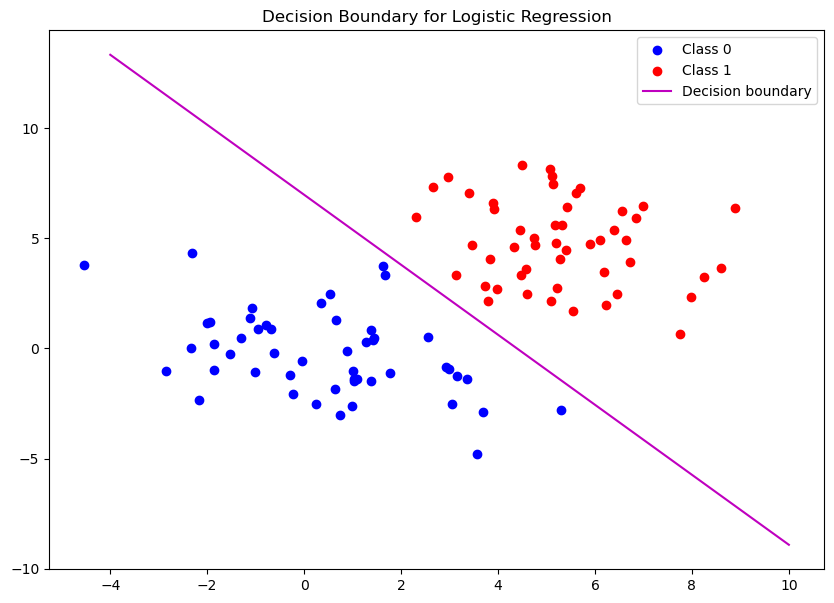

In [31]:
import matplotlib.pyplot as plt

theta = theta.value
c = - theta[0]/theta[2]
m = - theta[1]/theta[2]
x1 = np.linspace(-4,10,100)
x2 = m*x1 + c

plt.figure(figsize = (10,7))
plt.scatter(class_0['Data_1'], class_0['Data_2'], c='b')
plt.scatter(class_1['Data_1'], class_1['Data_2'], c='r')
plt.plot(x1, x2, c='m')
plt.legend(["Class 0", "Class 1", "Decision boundary"])
plt.title("Decision Boundary for Logistic Regression")

In [32]:
theta

array([[-10.43645136],
       [  2.37857414],
       [  1.49754409]])

### Bayesian Decision Rule

In [33]:
X = np.column_stack((Data_1, Data_2))
X_0 = X[0:50, :]
X_1 = X[50:, :]

K1 = class_1.shape[0]
K0 = class_0.shape[0]

pi_0 = K0/(K1+K0)
pi_1 = K1/(K1+K0)

mu_0 = np.mean(X_0, axis=0)
mu_1 = np.mean(X_1, axis=0)

sigma_0 = np.cov(X_0.T)
sigma_1 = np.cov(X_1.T)

In [34]:
sig_0_inv = np.linalg.inv(sigma_0)
sig_1_inv = np.linalg.inv(sigma_1)
sig_0_det = np.linalg.det(sigma_0)
sig_1_det = np.linalg.det(sigma_1)


In [35]:
N_points = 101
points = np.linspace(-5, 10, N_points)
xx, yy = np.meshgrid(points, points, sparse=True)
xx = np.reshape(xx, max(xx.shape))
yy = np.reshape(yy, max(yy.shape))

mesh = np.zeros((N_points, N_points))

for i in range(N_points):
    for j in range(N_points):
        block = np.array([xx[i], yy[j]])
        LHS = -0.5*np.matmul(np.matmul((block - mu_1).T, sig_1_inv),(block - mu_1)) + np.log(pi_1) - 0.5*np.log(sig_1_det)
        RHS = -0.5*np.matmul(np.matmul((block - mu_0).T, sig_0_inv),(block - mu_0)) + np.log(pi_0) - 0.5*np.log(sig_0_det)
        mesh[i,j] = 1 if (LHS > RHS) else 0


Text(0.5, 1.0, 'Bayesian Decision Rule')

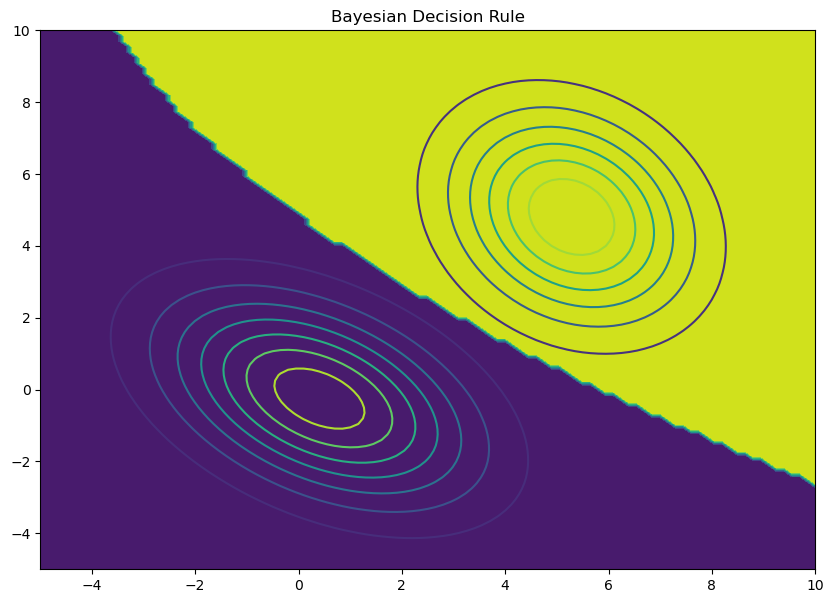

In [36]:
import scipy
gauss1 = scipy.stats.multivariate_normal(mu_1, sigma_1)
gauss0 = scipy.stats.multivariate_normal(mu_0, sigma_0)

XX, YY = np.meshgrid(points, points)
pos  = np.dstack((XX, YY))

Z0 = gauss0.pdf(pos)
Z1 = gauss1.pdf(pos)

fig = plt.figure(figsize=(10,7))
plt.contourf(XX, YY, mesh)
plt.contour(XX, YY, Z0)
plt.contour(XX, YY, Z1)
plt.title("Bayesian Decision Rule")

## Exercise 3

In [45]:
X = np.column_stack((Data_1, Data_2, Data_3))

h = 1
K = np.zeros((X.shape[0], X.shape[0]))
for m in range(X.shape[0]):
    for n in range(X.shape[0]):
        K[m, n] = np.exp(-np.sum((X[m]-X[n])**2)/h)

In [46]:
K[47:52, 47:52]

array([[1.00000000e+00, 5.05310080e-25, 6.06536602e-20, 4.65474122e-29,
        4.06890793e-17],
       [5.05310080e-25, 1.00000000e+00, 3.95931666e-13, 2.69357110e-33,
        5.38775392e-12],
       [6.06536602e-20, 3.95931666e-13, 1.00000000e+00, 2.30352619e-65,
        3.78419625e-34],
       [4.65474122e-29, 2.69357110e-33, 2.30352619e-65, 1.00000000e+00,
        2.16278503e-06],
       [4.06890793e-17, 5.38775392e-12, 3.78419625e-34, 2.16278503e-06,
        1.00000000e+00]])

In [47]:
alpha = cvx.Variable((N,1))
lambd = 0.0001

loss = -(cvx.sum(cvx.multiply(y, K @ alpha)) - cvx.sum(cvx.log_sum_exp( cvx.hstack([np.zeros((N,1)), K@alpha]), axis=1 ) )) /N + lambd*cvx.quad_form(alpha, K)
prob = cvx.Problem(cvx.Minimize(loss))
prob.solve()

0.0641699061939224

In [49]:
print(alpha.value[:2])

[[-0.95245074]
 [-1.21046707]]


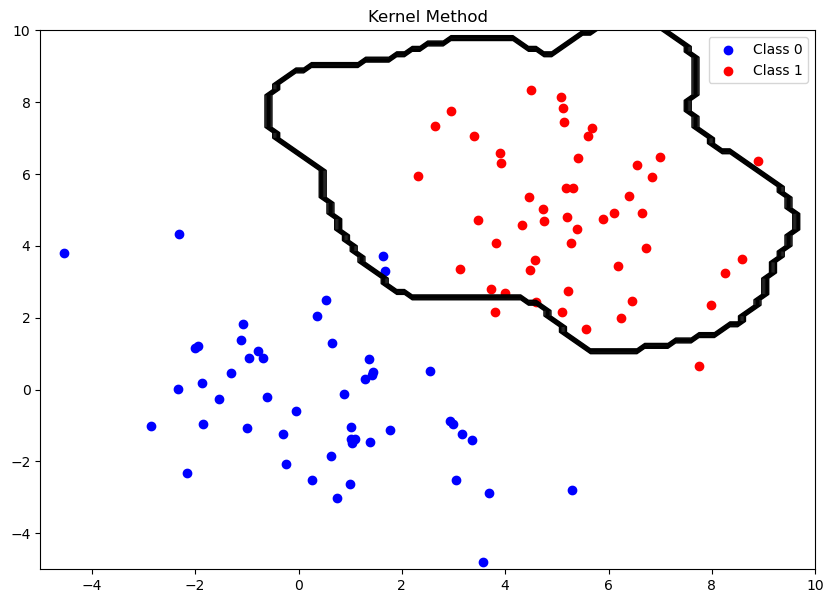

In [52]:
from numpy.matlib import repmat
N_points = 101
points = np.linspace(-5, 10, N_points)
xx, yy = np.meshgrid(points, points, sparse=True)
xx = np.reshape(xx, max(xx.shape))
yy = np.reshape(yy, max(yy.shape))

mesh = np.zeros((N_points, N_points))
alpha = alpha.value

for i in range(N_points):
    for j in range(N_points):
        block = repmat( np.array([xx[i], yy[j], 1]).reshape((1,3)), N, 1)
        s = block - X
        ks = np.exp(-np.sum(np.square(s)/h, axis=1))
        mesh[i,j] = np.dot(alpha.T, ks).item()

plt.figure(figsize=(10,7))
plt.scatter(class_0['Data_1'], class_0['Data_2'], c='b')
plt.scatter(class_1['Data_1'], class_1['Data_2'], c='r') 
plt.contour(xx, yy, mesh>0.5, linewidths=1, colors='k')
plt.legend(['Class 0', 'Class 1'])
plt.title('Kernel Method')
plt.show()